In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
from nlstruct.text import huggingface_tokenize, regex_sentencize, partition_spans, encode_as_tag, split_into_spans, apply_substitutions, apply_deltas
from nlstruct.dataloaders import load_from_brat, load_genia_ner
from nlstruct.collections import Dataset, Batcher
from nlstruct.utils import merge_with_spans, normalize_vocabularies, factorize_rows, df_to_csr, factorize, torch_global as tg
from nlstruct.modules.crf import BIODecoder, BIOULDecoder
from nlstruct.environment import root, cached
from nlstruct.train import seed_all
from itertools import chain, repeat

import networkx as nx
import numpy as np
import torch
import torch.nn.functional as F
import math

import pandas as pd
import numpy as np
import re
import string
from transformers import AutoModel, AutoTokenizer

In [4]:
pd.set_option('display.width', 1000)

In [5]:
# To debug the training, we can just comment the "def run_epoch()" and execute the function body manually without changing anything to it
def extract_mentions(batcher, all_nets, max_depth=10):
    """
    Parameters
    ----------
    batcher: Batcher 
        The batcher containing the text from which we want to extract the mentions (and maybe the gold mentions)
    ner_net: torch.nn.Module
    max_depth: int
        Max number of times we run the model per sample
        
    Returns
    -------
    Batcher
    """
    pred_batches = []
    n_mentions = 0
    ner_net = all_nets["ner_net"]
    with evaluating(all_nets):
        with torch.no_grad():
            for batch_i, batch in enumerate(batcher['sentence'].dataloader(batch_size=batch_size, shuffle=False, sparse_sort_on="token_mask", device=tg.device)):

                mask = batch["token_mask"]

                res = all_nets["ner_net"].forward(
                    tokens =         batch["token"],
                    mask =           mask,
                    return_mentions=True,
                    return_loss=False,
                )
                
                pred_batch = Batcher({
                    "mention": {
                        "mention_id": torch.arange(n_mentions, n_mentions+len(res['doc_id']), device=device),
                        "begin": res["begin"],
                        "end": res["end"],
                        "ner_label": res["ner_label"],
                        "@sentence_id": res["doc_id"],
                    },
                    "sentence": dict(batch["sentence", ["sentence_id", "doc_id"]]),
                    "doc": dict(batch["doc"])}, 
                    check=False)
                
                pred_batches.append(pred_batch)
                print(len(res["begin"]), " mentions predicted")
    return Batcher.concat(pred_batches)

In [6]:
from collections import defaultdict

# Define the training metrics
metrics_info = defaultdict(lambda: False)
flt_format = (5, "{:.4f}".format)
metrics_info.update({
    "train_loss": {"goal": 0, "format": flt_format},
    "train_ner_loss": {"goal": 0, "format": flt_format},
    #"train_recall": {"goal": 1, "format": flt_format, "name": "train_rec"},
    #"train_precision": {"goal": 1, "format": flt_format, "name": "train_prec"},
    "train_f1": {"goal": 1, "format": flt_format, "name": "train_f1"},
    
    "val_loss": {"goal": 0, "format": flt_format},
    "val_ner_loss": {"goal": 0, "format": flt_format},
    "val_label_loss": {"goal": 0, "format": flt_format},
    
    "val_f1": {"goal": 1, "format": flt_format, "name": "val_f1"},
    "val_3.1_f1": {"goal": 1, "format": flt_format, "name": "val_3.1_f1"},
    "val_3.2_f1": {"goal": 1, "format": flt_format, "name": "val_3.2_f1"},
    "val_macro_f1": {"goal": 1, "format": flt_format, "name": "val_macro_f1"},
    "val_sosy_f1": {"goal": 1, "format": flt_format, "name": "val_sosy_f1"},
    "val_pathologie_f1": {"goal": 1, "format": flt_format, "name": "val_patho_f1"},
    
    "duration": {"format": flt_format, "name": "   dur(s)"},
    "rescale": {"format": flt_format},
    "n_depth": {"format": flt_format},
    "n_matched": {"format": flt_format},
    "n_targets": {"format": flt_format},
    "n_observed": {"format": flt_format},
    "total_score_sum": {"format": flt_format},
    "lr": {"format": (5, "{:.2e}".format)},
})

In [7]:
from nlstruct.utils import encode_ids

In [10]:
#@cached
def preprocess_train(
    dataset,
    max_sentence_length,
    bert_name,
    ner_labels=None,
    unknown_labels="drop",
    vocabularies=None,
):
    """
    Parameters
    ----------
        dataset: Dataset
        max_sentence_length: int
            Max number of "words" as defined by the regex in regex_sentencize (so this is not the nb of wordpieces)
        bert_name: str
            bert path/name
        ner_labels: list of str 
            allowed ner labels (to be dropped or filtered)
        unknown_labels: str
            "drop" or "raise"
        vocabularies: dict[str; np.ndarray or list]
    Returns
    -------
    (pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, pd.DataFrame, dict[str; np.ndarray or list])
        docs:      ('split', 'text', 'doc_id')
        sentences: ('split', 'doc_id', 'sentence_idx', 'begin', 'end', 'text', 'sentence_id')
        mentions:  ('ner_label', 'doc_id', 'sentence_id', 'mention_id', 'depth', 'text', 'mention_idx', 'begin', 'end')
        tokens:    ('split', 'token', 'sentence_id', 'token_id', 'token_idx', 'begin', 'end', 'doc_id', 'sentence_idx')
        deltas:    ('doc_id', 'begin', 'end', 'delta')
        vocs: vocabularies to be reused later for encoding more data or decoding predictions
    """
    print("Dataset:", dataset)
    mentions = dataset["mentions"].rename({"label": "ner_label"}, axis=1)
    if ner_labels is not None:
        len_before = len(mentions)
        unknown_ner_labels = list(mentions[~mentions["ner_label"].isin(ner_labels)]["ner_label"].drop_duplicates())
        mentions = mentions[mentions["ner_label"].isin(ner_labels)]
        if len(unknown_ner_labels) and unknown_labels == "raise":
            raise Exception(f"Unkown labels in {len_before-len(mentions)} mentions: ", unknown_ner_labels)
    # Check that there is no mention overlap
    mentions = mentions.merge(dataset["fragments"].groupby(["doc_id", "mention_id"], as_index=False, observed=True).agg({"begin": "min", "end": "max"}))
    print("Transform texts...", end=" ")
    docs, deltas = apply_substitutions(
        dataset["docs"], *zip(
            #(r"(?<=[{}\\])(?![ ])".format(string.punctuation), r" "),
            #(r"(?<![ ])(?=[{}\\])".format(string.punctuation), r" "),
            ("(?<=[a-zA-Z])(?=[0-9])", r" "),
            ("(?<=[0-9])(?=[A-Za-z])", r" "),
        ), apply_unidecode=True)
    docs = docs.astype({"text": str})
    transformed_mentions = apply_deltas(mentions, deltas, on=['doc_id'])
    print("done")
    
    print("Splitting into sentences...", end=" ")
    sentences = regex_sentencize(
        docs, 
        reg_split=r"(?<=[.])(\s*\n+)|(?=, [0-9]\))",
        min_sentence_length=None, max_sentence_length=max_sentence_length,
        balance_parentheses=False,
        # balance_parentheses=True, # default is True
    )
    [mentions], sentences, sentence_to_docs = partition_spans([transformed_mentions], sentences, new_id_name="sentence_id", overlap_policy=False)
    n_sentences_per_mention = mentions.assign(count=1).groupby(["doc_id", "mention_id"], as_index=False).agg({"count": "sum", "text": tuple, "sentence_id": tuple})
    if n_sentences_per_mention["count"].max() > 1:
        display(n_sentences_per_mention.query("count > 1"))
        display(sentences[sentences["sentence_id"].isin(n_sentences_per_mention.query("count > 1")["sentence_id"].explode())]["text"].tolist())
        raise Exception("Some mentions could be mapped to more than 1 sentences ({})".format(n_sentences_per_mention["count"].max()))
    if sentence_to_docs is not None:
        mentions = mentions.merge(sentence_to_docs)
    mentions = mentions.assign(mention_idx=0).nlstruct.groupby_assign(["doc_id", "sentence_id"], {"mention_idx": lambda x: tuple(range(len(x)))})
    print("done")
    
    print("Tokenizing...", end=" ")
    tokenizer = AutoTokenizer.from_pretrained(bert_name)
    sentences["text"] = sentences["text"].str.lower()
    tokens = huggingface_tokenize(sentences, tokenizer, doc_id_col="sentence_id")
    
    print(tokens)
    
    mentions = split_into_spans(mentions, tokens, pos_col="token_idx", overlap_policy=False)
    print("done")
    
    print("Processing nestings (overlapping areas)...", end=" ")
    # Extract overlapping spans
    conflicts = (
        merge_with_spans(mentions, mentions, on=["doc_id", "sentence_id", ("begin", "end")], how="outer", suffixes=("", "_other"))
    )
    # ids1, and ids2 make the edges of the overlapping mentions of the same type (see the "ner_label")
    [ids1, ids2], unique_ids = factorize_rows(
        [conflicts[["doc_id", "sentence_id", "mention_id"]], 
         conflicts[["doc_id", "sentence_id", "mention_id_other"]]],
        mentions.eval("size=(end-begin)").sort_values("size")[["doc_id", "sentence_id", "mention_id"]]
    )
    g = nx.from_scipy_sparse_matrix(df_to_csr(ids1, ids2, n_rows=len(unique_ids), n_cols=len(unique_ids)))
    colored_nodes = np.asarray(list(nx.coloring.greedy_color(g, strategy=keep_order).items()))
    unique_ids['depth'] = colored_nodes[:, 1][colored_nodes[:, 0].argsort()]
    mentions = mentions.merge(unique_ids)
    print("done")
    
    print("Computing vocabularies...")
    [docs, sentences, mentions, tokens], vocs = normalize_vocabularies(
        [docs, sentences, mentions, tokens], 
        vocabularies={"split": ["train", "val", "test"]} if vocabularies is None else vocabularies,
        train_vocabularies={"source": False, "text": False} if vocabularies is None else False,
        verbose=True)
    print("done")
    
    prep = Dataset(docs=docs, sentences=sentences, mentions=mentions, tokens=tokens).copy()
    
    unique_mention_ids = encode_ids([mentions], ("doc_id", "sentence_id", "mention_id"))
    unique_sentence_ids = encode_ids([sentences, mentions, tokens], ("doc_id", "sentence_id"))
    unique_doc_ids = encode_ids([docs, sentences, mentions, tokens], ("doc_id",))
    
    batcher = Batcher({
        "mention": {
            "mention_id": mentions["mention_id"],
            "sentence_id": mentions["sentence_id"],
            "doc_id": mentions["doc_id"],
            "begin": mentions["begin"],
            "end": mentions["end"],
            "depth": mentions["depth"],
            "ner_label": mentions["ner_label"].cat.codes,
        },
        "sentence": {
            "sentence_id": sentences["sentence_id"],
            "doc_id": sentences["doc_id"],
            "mention_id": df_to_csr(mentions["sentence_id"], mentions["mention_idx"], mentions["mention_id"], n_rows=len(unique_sentence_ids)),
            "mention_mask": df_to_csr(mentions["sentence_id"], mentions["mention_idx"], n_rows=len(unique_sentence_ids)),
            "token": df_to_csr(tokens["sentence_id"], tokens["token_idx"], tokens["token"].cat.codes, n_rows=len(unique_sentence_ids)),
            "token_mask": df_to_csr(tokens["sentence_id"], tokens["token_idx"], n_rows=len(unique_sentence_ids)),
        },
        "doc": {
            "doc_id": np.arange(len(unique_doc_ids)),
            "sentence_id": df_to_csr(sentences["doc_id"], sentences["sentence_idx"], sentences["sentence_id"], n_rows=len(unique_doc_ids)),
            "sentence_mask": df_to_csr(sentences["doc_id"], sentences["sentence_idx"], n_rows=len(unique_doc_ids)),
            "split": docs["split"].cat.codes,
        }},
        masks={"sentence": {"token": "token_mask", "mention_id": "mention_mask"}, 
               "doc": {"sentence_id": "sentence_mask"}}
    )
    
    return batcher, prep, deltas, vocs

def keep_order(G, colors):
    """Returns a list of the nodes of ``G`` in ordered identically to their id in the graph
    ``G`` is a NetworkX graph. ``colors`` is ignored.
    This is to assign a depth using the nx.coloring.greedy_color function
    """
    return sorted(list(G))

In [14]:
prep['tokens']

,split,token,sentence_id,token_id,token_idx,begin,end,doc_id,sentence_idx
0,train,[CLS],MEDLINE:95369245/0,0,0,0,0,MEDLINE:95369245,0
1,train,il,MEDLINE:95369245/0,1,1,0,2,MEDLINE:95369245,0
2,train,-,MEDLINE:95369245/0,2,2,2,3,MEDLINE:95369245,0
3,train,2,MEDLINE:95369245/0,3,3,3,4,MEDLINE:95369245,0
4,train,gene,MEDLINE:95369245/0,4,4,5,9,MEDLINE:95369245,0
...,...,...,...,...,...,...,...,...,...
798171,test,2,MEDLINE:95370270/7,798171,87,281,282,MEDLINE:95370270,7
798172,test,secret,MEDLINE:95370270/7,798172,88,283,289,MEDLINE:95370270,7
798173,test,##ion,MEDLINE:95370270/7,798173,89,289,292,MEDLINE:95370270,7
798174,test,.,MEDLINE:95370270/7,798174,90,292,293,MEDLINE:95370270,7


In [15]:
prep['mentions']

,ner_label,sentence_id,doc_id,mention_id,text,mention_idx,begin,end,depth
0,DNA,MEDLINE:95369245/0,MEDLINE:95369245,0,IL-2 gene,0,1,5,0
1,protein,MEDLINE:95369245/0,MEDLINE:95369245,1,NF-kappa B,1,7,13,0
2,protein,MEDLINE:95369245/0,MEDLINE:95369245,2,CD28,2,15,18,0
3,protein,MEDLINE:95369245/0,MEDLINE:95369245,3,5-lipoxygenase,3,23,30,0
4,protein,MEDLINE:95369245/1,MEDLINE:95369245,4,CD28,0,4,7,0
...,...,...,...,...,...,...,...,...,...
57091,DNA,MEDLINE:95370270/7,MEDLINE:95370270,57091,AP-1 sites,6,34,39,1
57092,protein,MEDLINE:95370270/7,MEDLINE:95370270,57092,interleukin-3,7,44,50,0
57093,protein,MEDLINE:95370270/7,MEDLINE:95370270,57093,granulocyte macrophage colony-stimulating factor,8,51,65,0
57094,cell_type,MEDLINE:95370270/7,MEDLINE:95370270,57094,T cell,9,70,72,0


In [11]:
bert_name = "bert-base-cased"
dataset = load_genia_ner()
docs = dataset['docs']

keep_n_first = None

if keep_n_first:
    docs = docs[:keep_n_first]
    first_ids = docs['doc_id']
    
    first_mentions = dataset["mentions"].loc[dataset["mentions"]['doc_id'].isin(first_ids)]
    first_fragments = dataset["fragments"].loc[dataset["fragments"]['doc_id'].isin(first_ids)]
    first_attributes = dataset["attributes"].loc[dataset["attributes"]['doc_id'].isin(first_ids)]
    
    dataset["mentions"] = first_mentions
    dataset["fragments"] = first_fragments
    dataset["attributes"] = first_attributes

docs["split"] = ["train"] * (len(docs) - int(len(docs) * 0.1)) + ["test"] * int(len(docs) * 0.1)
dataset['docs'] = docs

batcher, prep, deltas, vocs = preprocess_train(
    dataset=dataset,
    max_sentence_length=140,
    bert_name=bert_name,
    ner_labels= ['DNA', 'protein', 'cell_type', 'cell_line', 'RNA'],
    unknown_labels="drop",
)

Dataset: Dataset(
  (docs):        2000 * ('doc_id', 'text', 'split')
  (mentions):   57096 * ('doc_id', 'mention_id', 'label', 'text')
  (fragments):  57096 * ('doc_id', 'mention_id', 'fragment_id', 'begin', 'end')
  (attributes):     0 * ('doc_id', 'mention_id', 'attribute_id', 'label', 'value')
)
Transform texts... done
Splitting into sentences... done
Tokenizing...                sentence_id  token_id  token_idx   token  begin  end            doc_id  sentence_idx  split
0       MEDLINE:95369245/0         0          0   [CLS]      0    0  MEDLINE:95369245             0  train
1       MEDLINE:95369245/0         1          1      il      0    2  MEDLINE:95369245             0  train
2       MEDLINE:95369245/0         2          2       -      2    3  MEDLINE:95369245             0  train
3       MEDLINE:95369245/0         3          3       2      3    4  MEDLINE:95369245             0  train
4       MEDLINE:95369245/0         4          4    gene      5    9  MEDLINE:95369245        

KeyboardInterrupt: 

In [10]:
from transformers import BertModel
bert, log = BertModel.from_pretrained(bert_name, output_loading_info=True)

In [11]:
#all_test_doc_ids = []
#sims = {}
#for i in range(200):
seed_all(1234567+137)

train_batcher = batcher['doc'][batcher['doc']['split']==0]['sentence']
test_batcher = batcher['doc'][batcher['doc']['split']==2]['sentence']

splits = np.zeros(len(train_batcher['doc']), dtype=int)

val_perc = 0.1
splits[np.random.choice(np.arange(len(splits)), size=int(val_perc * len(splits)))] = 1

val_batcher = test_batcher#batcher['sentence'][splits == 1]

# train_val_split = np.random.permutation(len(train_batcher))
# test_batcher = train_batcher[train_val_split[:int(0.1*len(train_val_split))]]['sentence']
# train_batcher = train_batcher[train_val_split[int(0.1*len(train_val_split)):]]['sentence']
sim = ((np.bincount(val_batcher['mention', 'ner_label'], minlength=len(vocs["ner_label"]))/len(val_batcher['mention']) -
np.bincount(train_batcher['mention', 'ner_label'], minlength=len(vocs["ner_label"]))/len(train_batcher['mention']))**2).sum()
print("Similarity (L2 dist) between train and val frequencies:", sim)
print("Frequencies")
#all_test_doc_ids.append((test_doc_ids, sim))
display(pd.DataFrame([
    {"index": "train", **dict(zip(vocs["ner_label"], np.bincount(train_batcher['mention', 'ner_label'], minlength=len(vocs["ner_label"]))/len(train_batcher['mention'])))},
    {"index": "val", **dict(zip(vocs["ner_label"], np.bincount(val_batcher['mention', 'ner_label'], minlength=len(vocs["ner_label"]))/len(val_batcher['mention'])))},
]))

Similarity (L2 dist) between train and val frequencies: 0.004900437003164877
Frequencies


,index,DNA,RNA,cell_line,cell_type,protein
0,train,0.176332,0.016980,0.068440,0.128091,0.610157
1,val,0.222606,0.021301,0.081558,0.112646,0.561888


In [21]:
from copy import deepcopy as dc

from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

def tensor_in_list(a, d):
    return any([(a == d_).all() for d_ in d if a.shape == d_.shape])

class NERNet(torch.nn.Module):
    def __init__(self, 
                 ner_labels_subset,
                 hidden_dim, 
                 last_layer_dim,
                 rnn_layers, 
                 dropout, 
                 embeddings=None,
                 n_tokens=None, 
                 token_dim=None, 
                 tag_scheme="bio",
                 max_tag_depth=3,
                 do_batch_norm=True,
                 use_lstm=True,
                ):
        super().__init__()
        if embeddings is not None:
            self.embeddings = embeddings
            try:
                n_tokens, token_dim = self.embeddings.weight.shape
            except:
                n_tokens, token_dim = self.embeddings.word_embeddings.weight.shape
        else:
            self.embeddings = torch.nn.Embedding(n_tokens, token_dim) if n_tokens > 0 else None
        assert token_dim is not None, "Provide token_dim or embeddings"
        
        self.ner_labels_subset = ner_labels_subset
        
        self.lstm_dense = torch.nn.Linear(token_dim, hidden_dim*2)
        self.lstm_dense1 = torch.nn.Linear(hidden_dim*2, hidden_dim*2)
        if use_lstm:
            self.lstm1 = torch.nn.LSTM(hidden_dim*2, 
                                  hidden_dim, dropout=dropout, batch_first=True, num_layers=rnn_layers, bidirectional=True)
            
        if tag_scheme == "bio":
            self.crf_list1 = torch.nn.ModuleList([BIODecoder(1, with_start_end_transitions=False) for _ in ner_labels_subset])
        elif tag_scheme == "bioul":
            self.crf_list1 = torch.nn.ModuleList([BIOULDecoder(1, with_start_end_transitions=False) for _ in ner_labels_subset])
        else:
            raise Exception(f'Allowed tag schemes are "bio" or "bioul": passed was {repr(tag_scheme)}')

        self.dense1 = torch.nn.Linear(hidden_dim*2, sum(crf.num_tags for crf in self.crf_list1))

        self.dropout = torch.nn.Dropout(dropout)
        self.max_tag_depth = max_tag_depth
        
        self.do_batch_norm = do_batch_norm
        if do_batch_norm:
            self.bn_embeddings = torch.nn.BatchNorm1d(token_dim)
            self.bn_lstm = torch.nn.BatchNorm1d(hidden_dim*2)
            
        self.use_lstm = use_lstm
    
    def forward(self, 
                tokens, 
                mask, 
                tags=None, 
                return_loss=False, 
                return_mentions=False, 
                reduction="mean",
               ):
        
        print("TOKEN SHAPE",tokens.shape)
        # Embed the tokens
        state = torch.cat([
            *((self.embeddings(tokens).masked_fill(~mask.unsqueeze(-1), 0),) if self.embeddings is not None else ()),
        ], dim=-1)
        
        if not self.use_lstm:
            state = torch.relu(self.lstm_dense(self.dropout(state)))
            state = torch.relu(self.lstm_dense1(self.dropout(state)))
            state = torch.relu(self.dense1(self.dropout(state))).reshape((*state.shape[:-1], -1, len(self.crf_list1))).permute(3, 0, 1, 2)

            mentions = {"begin": [], "end": [], "ner_label": [], "doc_id": []}
            
            for i, (ner_label_idx, crf) in enumerate(zip(self.ner_labels_subset, self.crf_list1)):
                argmax_tags = crf.decode(state[i], mask)
                extracted = crf.tags_to_spans(argmax_tags, mask)
                mentions["begin"].append(extracted["span_begin"])
                mentions["end"].append(extracted["span_end"])
                mentions["ner_label"].append(torch.full_like(extracted["span_label"], ner_label_idx))
                mentions["doc_id"].append(extracted["span_doc_id"])
                
            mentions["begin"] = torch.cat(mentions["begin"])
            mentions["end"] = torch.cat(mentions["end"])
            mentions["ner_label"] = torch.cat(mentions["ner_label"])
            mentions["doc_id"] = torch.cat(mentions["doc_id"])

            if return_loss:
                loss = -sum([crf(state[i], mask, tags[..., ner_label_idx], reduction="none") 
                                for i, (ner_label_idx, crf) in enumerate(zip(self.ner_labels_subset, self.crf_list1))]).mean()# / len(self.crf_list)
            return {
                # Run the linear CRF forward algorithm on the tokens to compute the loglikelihood of the targets
                "loss": sum([loss]) if return_loss else sum([]), 
                # Run the linear CRF Viterbi algorithm to compute the most likely sequence
                **mentions
            }
                
            
        # Run the lstm (first sort the sentences, pack them according to the mask,
        # unpack them and finally reorder them)
        sorter = torch.argsort(-mask.sum(1))
        invsorter = torch.argsort(sorter)
        
        
        print("STATE SHAPE BEFORE VIEW", state.shape)
        
        # batch_norm
        if self.do_batch_norm:
            normed_state = self.bn_embeddings(state.permute(0, 2, 1))
            # Compute the tags scores
            state_lstm = self.lstm_dense(normed_state.permute(0, 2, 1))
        else:
            state_lstm = self.lstm_dense(state)
            
        # FIRST LAYER OUTPUT COMPUTATION
        all_mentions = {"begin": [], "end": [], "ner_label": [], "doc_id": []}
        all_losses = []
        
        print(state_lstm.shape)
        print(pack_padded_sequence(state_lstm[sorter], mask[sorter].sum(1), batch_first=True))
        
        for tag_layer in range(self.max_tag_depth):
            state_lstm = pad_packed_sequence(
                self.lstm1(pack_padded_sequence(state_lstm[sorter] if tag_layer==0 else next_layer_input, mask[sorter].sum(1), batch_first=True))[0], 
                batch_first=True)[0]
            
            print("STATE LSTM SHAPE BEFORE VIEW", state_lstm.shape)
            
            state_lstm = state_lstm.view(*state_lstm.shape[:2], -1)[invsorter]
            
            print("STATE LSTM SHAPE AFTER VIEW", state_lstm.shape)
            
            if self.do_batch_norm:
                state_lstm = self.bn_lstm(state_lstm.permute(0, 2, 1)).permute(0, 2, 1)
            
            # Compute the tags scores
            state = self.dense1(self.dropout(state_lstm)).reshape((*state_lstm.shape[:-1], -1, len(self.crf_list1))).permute(3, 0, 1, 2)
            
            mentions = {"begin": [], "end": [], "ner_label": [], "doc_id": []}
            
            for i, (ner_label_idx, crf) in enumerate(zip(self.ner_labels_subset, self.crf_list1)):
                argmax_tags = crf.decode(state[i], mask)
                extracted = crf.tags_to_spans(argmax_tags, mask)
                mentions["begin"].append(extracted["span_begin"])
                mentions["end"].append(extracted["span_end"])
                mentions["ner_label"].append(torch.full_like(extracted["span_label"], ner_label_idx))
                mentions["doc_id"].append(extracted["span_doc_id"])
                
            for k in mentions:
                all_mentions[k].extend(mentions[k])
                
            mentions["begin"] = torch.cat(mentions["begin"])
            mentions["end"] = torch.cat(mentions["end"])
            mentions["ner_label"] = torch.cat(mentions["ner_label"])
            mentions["doc_id"] = torch.cat(mentions["doc_id"])

            if return_loss:
                loss1 = -sum([crf(state[i], mask, tags[..., ner_label_idx], reduction="none") 
                                for i, (ner_label_idx, crf) in enumerate(zip(self.ner_labels_subset, self.crf_list1))]).mean()# / len(self.crf_list)
            
                all_losses.append(loss1)
            
            if len(mentions["begin"]) == 0:
                for k in all_mentions:
                    if len(all_mentions[k]):
                        all_mentions[k] = torch.cat(all_mentions[k])
            
                return {
                    # Run the linear CRF forward algorithm on the tokens to compute the loglikelihood of the targets
                    "loss": sum(all_losses), 
                    # Run the linear CRF Viterbi algorithm to compute the most likely sequence
                    **all_mentions
                }#, {"loss":loss1, **all_mentions}
            
            # token_to_mention_mask => shape #n_sentences, sentence_size, n_mentions
#             token_to_mention_mask = torch.ones((*state_lstm.shape[:2], len(mentions['begin'])), device=state_lstm.device, dtype=torch.bool)
#             mentions_length = [e - b for b, e in zip(mentions["begin"], mentions["end"])]
            
#             mentions_state = torch.einsum('nld,nlm->dm', state_lstm, token_to_mention_mask.float())
            
#             mentions_state = mentions_state / torch.Tensor(mentions_length).to(state_lstm.device)
            
#             next_layer_input = state_lstm.clone()
#             next_layer_input[token_to_mention_mask.any(2)] = torch.einsum('dm,nlm->nld', mentions_state, token_to_mention_mask.float())[token_to_mention_mask.any(2)]
            
            next_layer_input = state_lstm.clone()
        
            for b, e in zip(mentions["begin"], mentions["end"]):
                # average representation of each detected mention
                next_layer_input[:,b:e].data = next_layer_input[:,b:e].clone().mean() #(1/1+e-b) * state_lstm[:,b:e].sum()
            
        for k in all_mentions:
            if len(all_mentions[k]):
                all_mentions[k] = torch.cat(all_mentions[k])

        return {
            # Run the linear CRF forward algorithm on the tokens to compute the loglikelihood of the targets
            "loss": sum(all_losses), 
            # Run the linear CRF Viterbi algorithm to compute the most likely sequence
            **all_mentions
        }#, {"loss": first_loss, **first_mentions}

In [22]:
# !pip install /home/yoann/these/DEFT/nlstruct/

In [23]:
import traceback
from tqdm import tqdm

from custom_bert import CustomBertModel
from transformers import AdamW, BertModel

from tqdm import tqdm
from scipy.sparse import csr_matrix
from logic_crf import CRF, ConstraintFactor, HintFactor, Indexer

from nlstruct.environment import get_cache
from nlstruct.utils import evaluating, torch_global as tg, freeze
from nlstruct.scoring import compute_metrics, merge_pred_and_gold
from nlstruct.train import make_optimizer_and_schedules, iter_optimization, seed_all
from nlstruct.train.schedule import ScaleOnPlateauSchedule, LinearSchedule, ConstantSchedule

from nlstruct.utils import torch_clone
    
device = torch.device('cuda')
tg.set_device(device)
all_preds = []
histories = []

# To release gpu memory before allocating new parameters for a new model
# A better idea would be to run xp in a function, so that all variables are released when exiting the fn
# but this way we can debug after this cell if something goes wrong
if "all_nets" in globals(): del all_nets
if "optim" in globals(): del optim, 
if "schedules" in globals(): del schedules
if "final_schedule" in globals(): del final_schedule
if "state" in globals(): del state
    
# Hyperparameter search
layer, hidden_dim, scheme, seed, lr, bert_lr, n_schedules, dropout = (13, 100, "bioul", 12,  7e-3, 6e-5, 4, 0.1)
#seed = 123456
seed_all(seed) # /!\ Super important to enable reproducibility

max_grad_norm = 5.
#lr = 1e-3
#bert_lr = 6e-5
tags_lr = bert_lr
bert_weight_decay = 0.0000
batch_size = 257
random_perm=True
observed_zone_sizes=None
n_per_zone = "uniform"
n_freeze = layer + 2#4
#hidden_dim = 256
bert_dropout = 0.2
top_dropout = dropout

dim = 100

ner_net = NERNet(
        n_tokens=len(vocs["token"]),
        token_dim=100,#768,
#             n_labels=len(vocs["ner_label"]),
        embeddings=torch_clone(bert.embeddings),
        dropout=top_dropout,
        hidden_dim=hidden_dim,
        tag_scheme=scheme,
        ner_labels_subset=list(range(len(vocs["ner_label"]))), 
        last_layer_dim=hidden_dim, 
        rnn_layers=2, 
#             metric='linear' # cosine might be better but looks less stable, oddly,
)
all_nets = torch.nn.ModuleDict({
    "ner_net": ner_net,
}).to(device=tg.device)
del ner_net

for module in all_nets["ner_net"].embeddings.modules():
    if isinstance(module, torch.nn.Dropout):
        module.p = bert_dropout
all_nets.train()

# Define the optimizer, maybe multiple learning rate / schedules per parameters groups
optim, schedules = make_optimizer_and_schedules(all_nets, AdamW, {
    "lr": [
                           (lr,    bert_lr,    bert_lr,    tags_lr),
        (ConstantSchedule, (lr,    bert_lr,    bert_lr,    tags_lr),    15),
        (ConstantSchedule, (lr/4,  bert_lr/4,  bert_lr/4,  tags_lr/4),  15),
        (ConstantSchedule, (lr/16, bert_lr/16, bert_lr/16, tags_lr/16), 10),
        (ConstantSchedule, (lr/64, bert_lr/64, bert_lr/64, tags_lr/64), 10),
    ][:n_schedules+1],
}, [
    "(?!ner_net\.embeddings\.).*", 
    "ner_net\.embeddings\..*(bias|LayerNorm\.weight)",
    "ner_net\.embeddings\..*(?!bias|LayerNorm\.weight)",
], num_iter_per_epoch=(len(train_batcher) + 1) / batch_size)
final_schedule = ScaleOnPlateauSchedule('lr', optim, patience=4, factor=0.25, verbose=True, mode='max')

# Freeze some bert layers 
# - n_freeze = 0 to freeze nothing
# - n_freeze = 1 to freeze word embeddings / position embeddings / ...
# - n_freeze = 2..13 to freeze the first, second ... 12th layer of bert
for name, param in all_nets.named_parameters():
    match = re.search("\.(\d+)\.", name)
    if match and int(match.group(1)) < n_freeze - 1:
        freeze([param])
if n_freeze > 0:
    if hasattr(all_nets['ner_net'].embeddings, 'embeddings'):
        freeze(all_nets['ner_net'].embeddings.embeddings)
    else:
        freeze(all_nets['ner_net'].embeddings)

with_tqdm = True
state = {"all_nets": all_nets, "optim": optim, "schedules": schedules, "final_schedule": final_schedule}  # all we need to restart the training from a given epoch

for epoch_before, state, history, record in iter_optimization(
    main_score = "val_f1", # do not earlystop based on validation
    metrics_info=metrics_info,
    max_epoch=81,
    patience=50,
    state=state, 
    cache_policy="all", # only store metrics, not checkpoints
    cache=get_cache("genia", {"seed": seed, "train_batcher": train_batcher, "val_batcher": None, "random_perm": random_perm, "observed_zone_sizes": observed_zone_sizes, "batch_size": batch_size, "max_grad_norm": max_grad_norm, **state}, loader=torch.load, dumper=torch.save),  # where to store the model (main name + hashed parameters)
    n_save_checkpoints=2,
#             exit_on_score=0.92,
):
    pred_batches = []
    gold_batches = []

    total_train_ner_loss = 0
    total_train_acc = 0
    total_train_ner_size = 0

    n_mentions = len(train_batcher["mention"])
    n_matched_mentions = 0
    n_target_mentions = 0
    n_observed_mentions = 0

    with tqdm(train_batcher['sentence'].dataloader(batch_size=batch_size, shuffle=True, sparse_sort_on="token_mask", device=device), disable=not with_tqdm) as bar:
        for batch_i, batch in enumerate(bar):
            optim.zero_grad()

            n_samples, sentence_size = batch["sentence", "token"].shape
            n_labels = len(vocs["ner_label"])
            
            mask = batch["token_mask"]

            # Compute the tokens label tag of the selected non-overlapping gold mentions to infer from the model
            target_tags = all_nets["ner_net"].crf_list1[0].spans_to_tags(
                batch["mention", "@sentence_id"] * n_labels + batch["mention", "ner_label"],
                batch["mention", "begin"],
                batch["mention", "end"], 
                torch.zeros_like(batch["mention", "ner_label"]), 
                n_tokens=sentence_size,
                n_samples=n_samples * n_labels,
            ) # [n_samples * n_labels] * sentence_size

            target_tags = target_tags.view(n_samples, n_labels, sentence_size)
            target_tags = target_tags.transpose(1, 2)
            
            # WITH DEPTH
            
#             # Compute the tokens label tag of the selected non-overlapping gold mentions to infer from the model
#             n_depth = batch["mention", "depth"].max().item() + 2
#             target_tags = all_nets["ner_net"].crf_list1[0].spans_to_tags(
#                 batch["mention", "@sentence_id"] + batch["mention", "depth"] * n_samples,
#                 batch["mention", "begin"],
#                 batch["mention", "end"], 
#                 batch["mention", "ner_label"], 
#                 n_tokens=sentence_size,
#                 n_samples=n_samples * n_depth,
#             ) # [n_samples * n_labels] * sentence_size
#             target_tags = target_tags.view(n_depth, n_samples, sentence_size)

            res = all_nets["ner_net"].forward(
                tokens =         batch["token"],
                mask =           mask,
                tags =           target_tags,
                return_mentions=True,
                return_loss=True,
            )

            loss = res['loss']
            total_train_ner_loss += float(loss) * len(batch["sentence"])
            total_train_ner_size += len(batch["sentence"])

            # Perform optimization step
            loss.backward()
            torch.nn.utils.clip_grad_norm_(all_nets.parameters(), max_grad_norm)
            optim.step()
            for schedule_name, schedule in schedules.items():
                schedule.step()
                
            pred_batch = Batcher({
                "mention": {
                    "mention_id": torch.arange(n_mentions, n_mentions+len(res['doc_id']), device=device),
                    "begin": res["begin"],
                    "end": res["end"],
                    "ner_label": res["ner_label"],
                    "@sentence_id": res["doc_id"],
                },
                "sentence": dict(batch["sentence", ["sentence_id", "doc_id"]]),
                "doc": dict(batch["doc"])}, 
                check=False)
            pred_batches.append(pred_batch)
            n_mentions += len(res['doc_id'])
            
    
    val_batches = []
    
    with tqdm(val_batcher['sentence'].dataloader(batch_size=batch_size, shuffle=True, sparse_sort_on="token_mask", device=device), disable=not with_tqdm) as bar:
        for batch_i, batch in enumerate(bar):
            optim.zero_grad()
            
            mask = batch["token_mask"]

            res = all_nets["ner_net"].forward(
                tokens =         batch["token"],
                mask =           mask,
                return_mentions=True,
                return_loss=False,
            )

            val_batch = Batcher({
                "mention": {
                    "mention_id": torch.arange(n_mentions, n_mentions+len(res['doc_id']), device=device),
                    "begin": res["begin"],
                    "end": res["end"],
                    "ner_label": res["ner_label"],
                    "@sentence_id": res["doc_id"],
                },
                "sentence": dict(batch["sentence", ["sentence_id", "doc_id"]]),
                "doc": dict(batch["doc"])}, 
                check=False)
            
            val_batches.append(val_batch)
            
    # Compute precision, recall and f1 on train set
    ner_pred = Batcher.concat(pred_batches)
    val_pred = Batcher.concat(val_batches)
    
    from nlstruct.scoring import compute_metrics, merge_pred_and_gold
    
    train_metrics = compute_metrics(merge_pred_and_gold(
        pred=pd.DataFrame(dict(ner_pred["mention", ["sentence_id", "begin", "end", "ner_label"]])), 
        gold=pd.DataFrame(dict(train_batcher["mention", ["sentence_id", "begin", "end", "ner_label"]])), 
        span_policy='exact',  # only partially match spans with strict bounds, we could also eval with 'exact' or 'partial'
        on=["sentence_id", ("begin", "end"), "ner_label"]), prefix='train_')[["train_recall", "train_precision", "train_f1"]].to_dict()

    val_metrics = compute_metrics(merge_pred_and_gold(
        pred=pd.DataFrame(dict(val_pred["mention", ["sentence_id", "begin", "end", "ner_label"]])), #extract_mentions(val_batcher, all_nets=all_nets)
        gold=pd.DataFrame(dict(val_batcher["mention", ["sentence_id", "begin", "end", "ner_label"]])), 
        span_policy='exact',  # only partially match spans with strict bounds, we could also eval with 'exact' or 'partial'
        on=["sentence_id", ("begin", "end"), "ner_label"]), prefix='val_')[["val_recall", "val_precision", "val_f1"]].to_dict()

    
    # final_schedule.step(val_f1, state["epoch"])

    record(
    {
        "train_ner_loss": total_train_ner_loss / max(total_train_ner_size, 1),
        **train_metrics,
        # **val_metrics,
        **val_metrics,
        "n_matched": n_matched_mentions,
        "lr": schedules['lr'].get_val()[0],
    })

Available CUDA devices 8
Current device cuda
Using cache /home/tannier/data/cache/genia/7dfa167ed717d361
Loading /home/tannier/data/cache/genia/7dfa167ed717d361/history.yaml... Done


epoch |    dur(s) |       lr | n_matched | train_f1 | train_ner_loss | val_f1
    1 |  119.7527 | 7.00e-03 |    0.0000 |   0.1116 |       174.4086 | 0.3621


/home/tannier/anaconda3/envs/yt_nlp/lib/python3.7/site-packages/nlstruct/train/helpers.py:138: UserWarning: Entry 'schedules' in the state seems to be mutable but has no load_state_dict/state_dict methods. This could lead to unpredictable behaviors.
  warn(f"Entry '{key}' in the state seems to be mutable but has no load_state_dict/state_dict methods. This could lead to unpredictable behaviors.")


    2 |   71.5648 | 7.00e-03 |    0.0000 |   0.6540 |        45.5370 | 0.5329
    3 |   72.6780 | 7.00e-03 |    0.0000 |   0.6773 |        44.7306 | 0.5343
    4 |   72.4068 | 7.00e-03 |    0.0000 |   0.6924 |        41.9649 | 0.5945
    5 |   71.5367 | 7.00e-03 |    0.0000 |   0.6983 |        41.0320 | 0.6203
    6 |   67.4816 | 7.00e-03 |    0.0000 |   0.6938 |        41.0912 | 0.5512
    7 |   69.0711 | 7.00e-03 |    0.0000 |   0.7038 |        41.0858 | 0.6140
    8 |   71.6682 | 7.00e-03 |    0.0000 |   0.7097 |        39.6520 | 0.6367
    9 |   71.5270 | 7.00e-03 |    0.0000 |   0.7097 |        40.3215 | 0.5495
   10 |   73.0896 | 7.00e-03 |    0.0000 |   0.7127 |        39.8914 | 0.5837
   11 |   71.7698 | 7.00e-03 |    0.0000 |   0.7143 |        38.5646 | 0.6361
   12 |   70.5173 | 7.00e-03 |    0.0000 |   0.7150 |        38.7304 | 0.6208
   13 |   72.2161 | 7.00e-03 |    0.0000 |   0.7191 |        38.3908 | 0.6277
   14 |   72.2939 | 7.00e-03 |    0.0000 |   0.7157 |           

  0%|          | 0/66 [00:00<?, ?it/s]

   71 |   69.7193 | 1.75e-03 |    0.0000 |   0.7740 |        66.0823 | 0.6909
TOKEN SHAPE torch.Size([257, 18])
STATE SHAPE BEFORE VIEW torch.Size([257, 18, 768])
torch.Size([257, 18, 200])
PackedSequence(data=tensor([[ 0.5043,  0.4335, -0.0854,  ...,  0.0195,  0.3043, -0.3007],
        [ 0.3785,  0.5840,  0.1604,  ..., -0.2488, -0.0015, -0.3719],
        [ 0.3987,  0.5234, -0.0079,  ..., -0.1260,  0.2055, -0.6104],
        ...,
        [-0.1935,  0.2165,  0.1457,  ...,  0.0651, -0.2512, -0.1704],
        [ 0.1180,  0.0531, -0.0799,  ...,  0.2969, -0.1157,  0.1206],
        [ 0.1415, -0.1061,  0.1540,  ..., -0.0825,  0.0643,  0.1110]],
       device='cuda:0', grad_fn=<PackPaddedSequenceBackward>), batch_sizes=tensor([257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 257, 255, 250,
        235, 188, 110,  35]), sorted_indices=None, unsorted_indices=None)
STATE LSTM SHAPE BEFORE VIEW torch.Size([257, 18, 200])
STATE LSTM SHAPE AFTER VIEW torch.Size([257, 18, 200])
STATE LSTM SHAPE B

  0%|          | 0/66 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [1]:
exit

# Test 
(to be fair, avoid executing this part of the notebook to often, or use the training set instead)

In [15]:
bert_name = "bert-large"
test_dataset=test_dataset#load_genia_ner()#load_from_brat(root.resource("deft_2020/t3-test"), doc_attributes={"source": "real"})
test_docs, test_sentences, test_zones, test_mentions, test_conflicts, test_tokens, test_deltas, _ = preprocess(
    dataset=test_dataset,
    max_sentence_length=120,
    ner_labels=list(vocs["ner_label"]),
    bert_name=bert_name,
    unknown_labels="drop",
    vocabularies=vocs,
)
test_batcher, test_encoded, test_ids = make_batcher(test_docs, test_sentences, test_zones, test_mentions, test_conflicts, test_tokens)

NameError: name 'test_dataset' is not defined

### Extract the test mentions

In [15]:
pred_batcher = extract_mentions(test_batcher, all_nets=all_nets)
gold_batcher = test_batcher

pred=pd.DataFrame(dict(pred_batcher["mention", ["sentence_id", "begin", "end", "ner_label", "mention_id"]]))
gold=pd.DataFrame(dict(gold_batcher["mention", ["@zone_id", "begin", "end", "ner_label", "mention_id"]]))
gold["sentence_id"] = gold_batcher["zone", "sentence_id"][gold["@zone_id"]]
all_preds.append(pred)

print("{: <15} {: <5} {: <5} {: <5}".format("ner_label", "f1", "prec", "rec"))
print("---------------------------------")
for ner_label_idx, ner_label in enumerate(vocs['ner_label']):
    merged = merge_pred_and_gold(
        pred.query(f'ner_label == {ner_label_idx}'), 
        gold.query(f'ner_label == {ner_label_idx}'), 
        span_policy='exact',  # only partially match spans with strict bounds, we could also eval with 'exact' or 'partial'
        on=["sentence_id", ("begin", "end"), "ner_label"], atom_gold_level=["mention_id"], atom_pred_level=["mention_id"])
    precision = merged['tp'].sum() / merged['pred_count'].sum()
    recall = merged['tp'].sum() / merged['gold_count'].sum()
    f1 = 2/(1/precision + 1/recall)
    f1, precision, recall
    print("{: <15} {:.3f} {:.3f} {:.3f}".format(str(ner_label), f1, precision, recall))
agg = compute_metrics(merge_pred_and_gold(
    pred,
    gold,
    span_policy='exact',  # only partially match spans with strict bounds, we could also eval with 'exact' or 'partial'
    on=["sentence_id", ("begin", "end"), "ner_label"], atom_gold_level=["mention_id"], atom_pred_level=["mention_id"]))
print("---------------------------------")
print("{: <15} {:.3f} {:.3f} {:.3f}".format("total", agg["f1"], agg["precision"], agg["recall"]))

ner_label       f1    prec  rec  
---------------------------------
pathologie      0.420 0.593 0.325
sosy            0.524 0.530 0.518
---------------------------------
total           0.514 0.534 0.496


In [16]:
from nlstruct.text import reverse_deltas

In [17]:
pred_test_batcher = extract_mentions(test_batcher, all_nets=all_nets)
df = pd.DataFrame(dict(pred_test_batcher["mention", ["sentence_id", "begin", "end", "ner_label", "mention_id", "depth"]]))

In [18]:
pred = (df
 .merge(
    test_encoded["tokens"][["sentence_id", "token_idx", "begin"]], 
    left_on=["sentence_id", "begin"], right_on=["sentence_id", "token_idx"], suffixes=('_token', '')).drop(columns=["token_idx"])
 .eval("end=end-1")
 .merge(
    test_encoded["tokens"][["sentence_id", "token_idx", "end"]], 
    left_on=["sentence_id", "end"], right_on=["sentence_id", "token_idx"], suffixes=('_token', '')).drop(columns=["token_idx"])
).drop(columns=["begin_token", "end_token"])
pred = pred.merge(test_encoded["sentences"][["sentence_id", "begin", "end"]], on=["sentence_id"], suffixes=("", "_sent")).eval(
"""begin=begin+begin_sent
end=end+begin_sent
""").reset_index(drop=True)
pred["doc_id"] = test_ids["sentence_id"]["doc_id"].iloc[pred["sentence_id"]].reset_index(drop=True)
pred["ner_label"] = vocs["ner_label"][pred["ner_label"]]
pred = pred.drop(columns=["sentence_id", "begin_sent", "end_sent"])
pred = reverse_deltas(pred, test_deltas, on=["doc_id"])#.query("doc_id == 'filehtml-24-cas'").sort_values("begin")

In [19]:
pd.set_option('display.max_colwidth', 30000)
pd.set_option('display.max_columns', 30000)
pd.set_option('display.max_rows', 1000)

In [20]:
# x = Prediction
x = pred.merge(test_dataset["docs"][["doc_id", "text"]])
x["text_before"] = x.apply(lambda x: x["text"][x["begin"]-20:x["begin"]], axis=1)
x["text_after"] = x.apply(lambda x: x["text"][x["end"]:x["end"]+20], axis=1)
x["text"] = x.apply(lambda x: x["text"][x["begin"]:x["end"]], axis=1)
x["ner_label"] = x["ner_label"].astype(str)
x = x[["doc_id", "begin", "end", "text_before", "text", "text_after", "ner_label", "depth"]].rename({"depth": "step"}, axis=1)
x = x.sort_values(["doc_id", "begin"])

In [36]:
# y = Gold
y = test_dataset["mentions"].rename({"label": "ner_label"}, axis=1).merge(test_dataset["fragments"]).drop(columns=["text"])
y = y[y["doc_id"].isin(x["doc_id"])]
y = y.merge(test_mentions[["doc_id", "mention_id", "depth", "zone_id"]])
y = y.merge(test_dataset["docs"][["doc_id", "text"]])
y["text_before"] = y.apply(lambda x: x["text"][x["begin"]-20:x["begin"]], axis=1)
y["text_after"] = y.apply(lambda x: x["text"][x["end"]:x["end"]+20], axis=1)
y["text"] = y.apply(lambda x: x["text"][x["begin"]:x["end"]], axis=1)
y["ner_label"] = y["ner_label"].astype(str)
y = y[["doc_id", "begin", "end", "text_before", "text", "text_after", "ner_label", "depth", "zone_id"]]
y = y.merge(y[["zone_id", "depth"]].eval("zone_size = depth").groupby("zone_id", as_index=False).agg({"zone_size": "max"}))
y = y.sort_values(["doc_id", "begin"])

merged = merge_pred_and_gold(x, y, on=['doc_id', 'begin', 'end', 'ner_label', 'text_before', 'text', 'text_after'])

In [37]:
compute_metrics(merged)#.query("ner_label.isin(['sosy', 'pathologie'])"))

recall           0.496194
precision        0.534676
f1               0.514716
pred_count    1341.000000
gold_count    1445.000000
tp             717.000000
dtype: float64

In [24]:
# Je ne sais plus trop ce qu'il se passe dans cellules avec w et tout en dessous

In [26]:
w = merged_subset.query('tp == 0 and gold_count == 1')[["doc_id", "begin", "end", "ner_label", "text"]]
rel = factorize_rows(w, merged_subset.query('tp == 1')[['doc_id', 'begin', 'end']], subset=['doc_id', 'begin', 'end'], return_categories=False)

In [30]:
merge_pred_and_gold(x, w[rel != -1], on=['doc_id', ('begin', 'end')]).head()

,overlap_size_0,doc_id,begin_pred,end_pred,text_before,text_pred,text_after,ner_label_pred,step,begin_gold,end_gold,ner_label_gold,text_gold,pred_count,gold_count,tp,root
0,NaN,filehtml-146-cas,122.0,133.0,patiente de 40 ans,épileptique,.\n\nLe geste est réal,sosy,0.0,NaN,NaN,NaN,NaN,1,0,0,0
1,NaN,filehtml-146-cas,1129.0,1140.0,\nIl n'y a eu aucune,conséquence,pour la patiente en,sosy,0.0,NaN,NaN,NaN,NaN,1,0,0,0
2,NaN,filehtml-146-cas,1174.0,1191.0,nte en dehors d'une,légère somnolence,.\n,sosy,0.0,NaN,NaN,NaN,NaN,1,0,0,0
3,NaN,filepdf-106-cas,84.0,122.0,Elle n'avait pas d',antécédents pathologiques particuliers,et elle rapportait,sosy,0.0,NaN,NaN,NaN,NaN,1,0,0,0
4,NaN,filepdf-106-cas,160.0,224.0,t depuis 6 mois des,douleurs épisodiques localisées au niveau de l’hypochondre droit,sans irradiation et,sosy,0.0,NaN,NaN,NaN,NaN,1,0,0,0


In [31]:
from nlstruct.scoring import compute_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

### Train full

In [34]:
merged_span_only = merge_pred_and_gold(x, y, on=['doc_id', 'begin', 'end'])
z, labels_str = factorize_rows([merged_span_only.query('tp == 1')["ner_label_pred"], merged_span_only.query('tp == 1')["ner_label_gold"]])
labels_str = list(labels_str.astype(str))

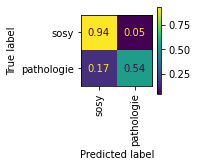

In [35]:
confusion = compute_confusion_matrix(z[0], z[1], n_labels=len(labels_str))
disp = ConfusionMatrixDisplay(confusion, labels_str)
_, ax = plt.subplots(1, 1, figsize=(0.8*len(labels_str), 0.8*len(labels_str)))
disp.plot(include_values=True, ax=ax, xticks_rotation="vertical", values_format=".2f")

In [38]:
for zone_size, group in merged.groupby("zone_size"):
    u = group.query('tp == 1').astype({"step": int, "depth": int})
    n = len(u.drop_duplicates("zone_id"))
    u = u.groupby(["depth", "step"]).size().unstack("step").fillna(0)
    print("size=", zone_size, "n_zones=", n)
    display(u)

size= 0.0 n_zones= 714


step,0,1
depth,,
0,707,7


size= 1.0 n_zones= 3


step,0
depth,
0,1
1,2


In [39]:
u = merged.query('tp == 1')[['step', 'depth', "ner_label"]].astype({"step": int, "depth": int})
u = u.groupby(["depth", "step"]).size().unstack("step")
u

step,0,1
depth,,
0,708.0,7.0
1,2.0,NaN


In [40]:
from sklearn.metrics import ConfusionMatrixDisplay

In [41]:
import matplotlib.pyplot as plt

[[<matplotlib.axis.YTick at 0x7fd5ea2eca10>,
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')],
 Text(0, 0.5, 'Depth'),
 [Text(0, 0, '0'), Text(0, 0, '1'), Text(0, 0, '2')],
 Text(0.5, 0, 'Step')]

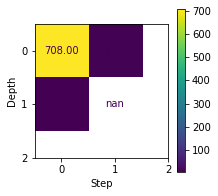

In [42]:
depths_str = ["0", "1", "2"]
steps_str = ["0", "1", "2"]
size = 1.5
disp = ConfusionMatrixDisplay(u.values, depths_str)
_, ax = plt.subplots(1, 1, figsize=(size*len(labels_str), size*len(labels_str)))
disp.plot(include_values=True, ax=ax, xticks_rotation="horizontal", values_format=".2f", )
disp.ax_.set(xticks=np.arange(len(depths_str)),
       yticks=np.arange(len(steps_str)),
       xticklabels=depths_str,
       yticklabels=steps_str,
       ylabel="Depth",
       xlabel="Step")

# Voting classifier

In [56]:
rel = factorize_rows(pred_a, categories=pred_cat, subset=["doc_id", "begin", "end", "ner_label"], return_categories=False)

In [ ]:
pred = (df
 .merge(
    encoded["tokens"][["sentence_id", "token_idx", "begin"]], 
    left_on=["sentence_id", "begin"], right_on=["sentence_id", "token_idx"], suffixes=('_token', ''), how='left').drop(columns=["token_idx"])
 .eval("end=end-1")
 .merge(
    test_encoded["tokens"][["sentence_id", "token_idx", "end"]], 
    left_on=["sentence_id", "end"], right_on=["sentence_id", "token_idx"], suffixes=('_token', ''), how='left').drop(columns=["token_idx"])
).drop(columns=["begin_token", "end_token"])
pred = pred.merge(test_encoded["sentences"][["sentence_id", "begin", "end"]], on=["sentence_id"], suffixes=("", "_sent")).eval(
"""begin=begin+begin_sent
end=end+begin_sent
""").reset_index(drop=True)
pred["doc_id"] = test_ids["sentence_id"]["doc_id"].iloc[pred["sentence_id"]].reset_index(drop=True)
pred["ner_label"] = vocs["ner_label"][pred["ner_label"]]
pred = pred.drop(columns=["sentence_id", "begin_sent", "end_sent"])
pred = reverse_deltas(pred, deltas, on=["doc_id"])#.query("doc_id == 'filehtml-24-cas'").sort_values("begin")

In [84]:
y = pred_a.merge(test_dataset["docs"][["doc_id", "text"]])
y["text_before"] = y.apply(lambda x: x["text"][x["begin"]-20:x["begin"]], axis=1)
y["text_after"] = y.apply(lambda x: x["text"][x["end"]:x["end"]+20], axis=1)
y["text"] = y.apply(lambda x: x["text"][x["begin"]:x["end"]], axis=1)
y.query("doc_id == 'filepdf-839-cas' and begin > 1300 and end < 1600")

,ner_label,mention_id,begin,end,doc_id,text,text_before,text_after
398,traitement,1650,1307,1325,filepdf-839-cas,ouverture du kyste,tectomie en bloc. L’,donne issue à un li
399,anatomie,1651,1451,1469,filepdf-839-cas,hydatique mammaire,imprévu d’un kyste,.\n\nL’étude histologi
400,pathologie,1718,1445,1469,filepdf-839-cas,kyste hydatique mammaire,stique imprévu d’un,.\n\nL’étude histologi
416,examen,3034,1474,1492,filepdf-839-cas,étude histologique,atique mammaire.\n\nL’,du prélèvement préc
417,examen,3035,1496,1507,filepdf-839-cas,prélèvement,ude histologique du,précise que le kyst
418,anatomie,3036,1547,1556,filepdf-839-cas,membranes,e est formé par des,faiblement acidophi
423,sosy,3108,1523,1591,filepdf-839-cas,kyste est formé par des membranes faiblement acidophiles feuilletées,ment précise que le,avec la présence de


In [85]:
y = pred_b.merge(test_dataset["docs"][["doc_id", "text"]])
y["text_before"] = y.apply(lambda x: x["text"][x["begin"]-20:x["begin"]], axis=1)
y["text_after"] = y.apply(lambda x: x["text"][x["end"]:x["end"]+20], axis=1)
y["text"] = y.apply(lambda x: x["text"][x["begin"]:x["end"]], axis=1)
y.query("doc_id == 'filepdf-839-cas' and begin > 1300 and end < 1600")

,ner_label,mention_id,begin,end,doc_id,text,text_before,text_after
401,traitement,1652,1307,1316,filepdf-839-cas,ouverture,tectomie en bloc. L’,du kyste donne issu
402,anatomie,1653,1451,1469,filepdf-839-cas,hydatique mammaire,imprévu d’un kyste,.\n\nL’étude histologi
403,sosy,1722,1445,1469,filepdf-839-cas,kyste hydatique mammaire,stique imprévu d’un,.\n\nL’étude histologi
419,examen,3021,1474,1492,filepdf-839-cas,étude histologique,atique mammaire.\n\nL’,du prélèvement préc
420,examen,3022,1496,1507,filepdf-839-cas,prélèvement,ude histologique du,précise que le kyst
421,sosy,3023,1523,1591,filepdf-839-cas,kyste est formé par des membranes faiblement acidophiles feuilletées,ment précise que le,avec la présence de
425,anatomie,3090,1547,1556,filepdf-839-cas,membranes,e est formé par des,faiblement acidophi


In [83]:
y = pred_c.merge(test_dataset["docs"][["doc_id", "text"]])
y["text_before"] = y.apply(lambda x: x["text"][x["begin"]-20:x["begin"]], axis=1)
y["text_after"] = y.apply(lambda x: x["text"][x["end"]:x["end"]+20], axis=1)
y["text"] = y.apply(lambda x: x["text"][x["begin"]:x["end"]], axis=1)
y.query("doc_id == 'filepdf-839-cas' and begin > 1300 and end < 1600")

,ner_label,mention_id,begin,end,doc_id,text,text_before,text_after
403,traitement,1664,1307,1325,filepdf-839-cas,ouverture du kyste,tectomie en bloc. L’,donne issue à un li
404,anatomie,1665,1451,1469,filepdf-839-cas,hydatique mammaire,imprévu d’un kyste,.\n\nL’étude histologi
405,sosy,1734,1445,1469,filepdf-839-cas,kyste hydatique mammaire,stique imprévu d’un,.\n\nL’étude histologi
421,examen,3044,1474,1492,filepdf-839-cas,étude histologique,atique mammaire.\n\nL’,du prélèvement préc
422,examen,3045,1496,1507,filepdf-839-cas,prélèvement,ude histologique du,précise que le kyst
423,anatomie,3046,1547,1556,filepdf-839-cas,membranes,e est formé par des,faiblement acidophi


# Export

In [39]:
import os

def export_mentions_to_brat(dataset, path=None, export_text=False, raise_empty_mentions=True):
    doc_id_to_text = dict(zip(dataset["docs"]["doc_id"], dataset["docs"]["text"]))
    try:
        os.mkdir(path)
    except FileExistsError:
        pass
    for doc_id, mentions in dataset["mentions"].groupby("doc_id"):
        if export_text:
            f = None
            try:
                if path is not None:
                    f = open("{}/{}.text".format(path, doc_id), "w")
                else:
                    print("File :", "{}.txt".format(doc_id))
                print(doc_id_to_text[doc_id], file=f)
            finally:
                f.close()
        f = None
        try:
            if path is not None:
                f = open("{}/{}.ann".format(path, doc_id), "w")
            else:
                print("File :", "{}.ann".format(doc_id))
            
            mention_counter = 0
            
            for mention_i, (_, row) in enumerate(mentions.sort_values("begin").iterrows()):
                mention_counter += 1
                text = doc_id_to_text[doc_id][row["begin"]:row["end"]]
                idx = row["begin"]
                spans = []
                ner_label = str(row["ner_label"])
                if "\n" in text:
                    print(repr(text), row["ner_label"])
                for part in text.split("\n"):
                    begin = idx
                    end = idx + len(part)
                    idx = end + 1
                    if begin != end:
                        spans.append((begin, end))
                    elif raise_empty_mentions:
                        raise Exception(f"Empty mention in {doc_id}: {begin}-{end} ({ner_label})")
                print("T{}\t{} {}\t{}".format(mention_i+1, ner_label, ";".join(" ".join(map(str, span)) for span in spans), text.replace("\n", " ")), file=f)
        finally:
            if f is not None:
                f.close()

#pred_path = "/home/shared/resources/deft_2020/equipe-LIMICS-tache3-run-2" # 999b3b047bce084f
export_mentions_to_brat(
    Dataset(
        docs=test_dataset["docs"],
        mentions=test_dataset["fragments"]
    ),
    path="/home/yoann/these/DEFT/preds/genia",
    export_text=False,
)

KeyError: 'ner_label'

In [15]:
gold_mentions = test_dataset["mentions"].merge(test_dataset["fragments"], on=["doc_id", "mention_id"])

In [16]:
from os import path

def preds_to_ann(
    mentions,
    dataset,
    ann_path,
):
    
    from pathlib import Path
    Path(ann_path).mkdir(parents=True, exist_ok=True)

    for doc_id in dataset['docs']['doc_id']:
        doc_mentions = mentions[mentions['doc_id']==doc_id]
        
        m_list = [f'T{i}\t{m.label} {m.begin} {m.end}\t{m.text}'\
        for i, (_,m) in enumerate(doc_mentions[~doc_mentions['text'].str.contains('\n')].iterrows())]
        ann_str = '\n'.join(m_list)
        
        txt_str = dataset['docs'][dataset['docs']['doc_id']==doc_id].text.tolist()[0]
        
        # Handle linebreaks in predictions
        # For now by separating into several entities
        if sum(doc_mentions['text'].str.contains('\n')) > 0:
            i = len(m_list)
            j = 0
            
            for _,m in doc_mentions[doc_mentions['text'].str.contains('\n')].iterrows():
                lines = m.text.split('\n')
                begin = m.begin
                span_str = f'{begin}'
                char_skip = 0
                for l in lines:
                    if l != '':
                        begin += char_skip
                        end = begin + len(l)
                        ann_str += f'\nT{i+j}\t{m.label} {begin} {end}\t{l}'
                        begin = end + 1
                        j += 1
                        char_skip = 0
                    else:
                        char_skip += 1
        
        with open(path.join(ann_path, f'{doc_id}.a2'), 'w') as f:
            f.write(ann_str)
            
#         with open(path.join(ann_path, f'{doc_id}.txt'), 'w') as f:
#             f.write(txt_str)
            
from datetime import datetime
now = datetime.now().strftime('%d%m_%H%M%S')

prediction_path = f'/home/yoann/these/DEFT/preds/genia/{now}'
                
preds_to_ann(gold_mentions, test_dataset, prediction_path)